In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score,silhouette_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.linear_model import LogisticRegression
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from kneed import KneeLocator
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the data
df = pd.read_csv('hltv_playerStats-complete.csv')
df.head()

,nick,country,stats_link,teams,maps_played,rounds_played,kd_difference,kd_ratio,rating,total_kills,headshot_percentage,total_deaths,grenade_damage_per_round,kills_per_round,assists_per_round,deaths_per_round,teammate_saved_per_round,saved_by_teammate_per_round,kast,impact
0,ZywOo,France,https://www.hltv.org//stats/players/11893/zywoo,"['Vitality', 'aAa']",970,25491,5917,1.38,1.27,21602,41.3,15685,3.6,0.85,0.13,0.62,0.10,0.12,74.9,1.45
1,s1mple,Ukraine,https://www.hltv.org//stats/players/7998/s1mple,['Natus Vincere'],1532,40464,8864,1.34,1.25,34647,41.3,25783,2.4,0.86,0.10,0.64,0.08,0.11,74.2,1.36
2,sh1ro,Russia,https://www.hltv.org//stats/players/16920/sh1ro,"['Gambit Youngsters', 'Gambit']",847,22465,5361,1.45,1.23,17320,27.9,11959,3.9,0.77,0.11,0.53,0.08,0.11,76.3,1.21
3,deko,Russia,https://www.hltv.org//stats/players/20113/deko,['1WIN'],378,10219,2225,1.37,1.22,8219,36.9,5994,3.3,0.80,0.10,0.59,0.09,0.11,74.5,1.21
4,Kaze,Malaysia,https://www.hltv.org//stats/players/8950/kaze,"['ViCi', 'Flash', 'MVP.karnal']",829,21617,4118,1.32,1.20,16957,30.3,12839,2.9,0.78,0.11,0.59,0.08,0.10,73.7,1.24


In [3]:
print(df["country"].unique().tolist())

['France', 'Ukraine', 'Russia', 'Malaysia', 'United Kingdom', 'New Zealand', 'Turkey', 'Hungary', 'China', 'Denmark', 'Bosnia and Herzegovina', 'Indonesia', 'Brazil', 'Korea', 'Singapore', 'Romania', 'Australia', 'Poland', 'Czech Republic', 'Slovakia', 'Mongolia', 'Hong Kong', 'Estonia', 'Bulgaria', 'Finland', 'United States', 'Thailand', 'Canada', 'Uruguay', 'Sweden', 'Spain', 'Germany', 'Belarus', 'Israel', 'South Africa', 'Belgium', 'Lithuania', 'Serbia', 'Latvia', 'Argentina', 'Norway', 'Netherlands', 'Kazakhstan', 'Guatemala', 'Jordan', 'Kosovo', 'Mexico', 'Montenegro', 'Portugal', 'North Macedonia', 'Taiwan', 'Switzerland', 'Uzbekistan']


In [4]:
country_tiers = {
    1: [
        'France', 'United Kingdom', 'New Zealand', 'Denmark', 'Finland', 
        'United States', 'Canada', 'Sweden', 'Spain', 'Germany', 
        'Belgium', 'Norway', 'Netherlands', 'Switzerland', 'Australia'
    ],
    2: [
        'Ukraine', 'Russia', 'Malaysia', 'Turkey', 'Hungary', 'China', 
        'Bosnia And Herzegovina', 'Indonesia', 'Brazil', 'Korea', 
        'Singapore', 'Romania', 'Poland', 'Czech Republic', 'Slovakia', 
        'Hong Kong', 'Estonia', 'Bulgaria', 'Lithuania', 'Serbia', 
        'Latvia', 'Argentina', 'Kazakhstan', 'Mexico', 'Montenegro', 
        'Portugal', 'Uruguay', 'Thailand', 'South Africa', 'Israel', 'Belarus'
    ],
    3: [
        'Mongolia', 'Guatemala', 'Jordan', 'Kosovo', 'North Macedonia', 
        'Uzbekistan', 'Taiwan'
    ]
}


In [5]:
df["country"] = df["country"].str.strip()
df["country"] = df["country"].str.title()  # Ensures title case for all country names

# Inverting the dictionary
mappable_dict = {country: tier for tier, countries in country_tiers.items() for country in countries}

df["country_tier"] = df["country"].map(mappable_dict)
df["country_tier"]


0      1
1      2
2      2
3      2
4      2
      ..
798    2
799    1
800    1
801    2
802    1
Name: country_tier, Length: 803, dtype: int64

In [6]:
df["country_tier"].isna().sum()

0

In [7]:
# Removing unnecesarry columns
num_df = df.copy()
num_df.drop(columns=["nick","stats_link","teams","country"],inplace=True)
num_df.head()

,maps_played,rounds_played,kd_difference,kd_ratio,rating,total_kills,headshot_percentage,total_deaths,grenade_damage_per_round,kills_per_round,assists_per_round,deaths_per_round,teammate_saved_per_round,saved_by_teammate_per_round,kast,impact,country_tier
0,970,25491,5917,1.38,1.27,21602,41.3,15685,3.6,0.85,0.13,0.62,0.10,0.12,74.9,1.45,1
1,1532,40464,8864,1.34,1.25,34647,41.3,25783,2.4,0.86,0.10,0.64,0.08,0.11,74.2,1.36,2
2,847,22465,5361,1.45,1.23,17320,27.9,11959,3.9,0.77,0.11,0.53,0.08,0.11,76.3,1.21,2
3,378,10219,2225,1.37,1.22,8219,36.9,5994,3.3,0.80,0.10,0.59,0.09,0.11,74.5,1.21,2
4,829,21617,4118,1.32,1.20,16957,30.3,12839,2.9,0.78,0.11,0.59,0.08,0.10,73.7,1.24,2


In [8]:
# All the data is numerical
num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   maps_played                  803 non-null    int64  
 1   rounds_played                803 non-null    int64  
 2   kd_difference                803 non-null    int64  
 3   kd_ratio                     803 non-null    float64
 4   rating                       803 non-null    float64
 5   total_kills                  803 non-null    int64  
 6   headshot_percentage          803 non-null    float64
 7   total_deaths                 803 non-null    int64  
 8   grenade_damage_per_round     803 non-null    float64
 9   kills_per_round              803 non-null    float64
 10  assists_per_round            803 non-null    float64
 11  deaths_per_round             803 non-null    float64
 12  teammate_saved_per_round     803 non-null    float64
 13  saved_by_teammate_pe

In [9]:
num_df.describe().T

,count,mean,std,min,25%,50%,75%,max
maps_played,803.0,833.174346,402.388811,374.00,500.50,734.00,1059.00,2169.00
rounds_played,803.0,21893.596513,10607.751477,9498.00,13227.00,19174.00,27881.00,56914.00
kd_difference,803.0,585.465753,1475.806605,-6238.00,-283.00,358.00,1313.50,8864.00
kd_ratio,803.0,1.035430,0.092114,0.74,0.98,1.03,1.09,1.45
rating,803.0,1.011880,0.066560,0.77,0.97,1.01,1.05,1.27
total_kills,803.0,15142.087173,7539.729631,5530.00,9092.50,13132.00,19214.00,40884.00
headshot_percentage,803.0,45.462017,8.416641,23.60,40.50,47.30,51.45,68.40
total_deaths,803.0,14556.518057,7018.031710,5994.00,8842.50,12603.00,18226.50,38351.00
grenade_damage_per_round,803.0,4.061395,1.187467,1.40,3.20,3.90,4.80,9.10
kills_per_round,803.0,0.688904,0.044705,0.52,0.66,0.69,0.72,0.86


In [10]:
scaler = StandardScaler()
num_df_scaled = num_df.iloc[:,:-1].copy()
for f in num_df.columns:
    num_df_scaled[f]=scaler.fit_transform(num_df[[f]])
num_df_scaled["country_tier"] = num_df["country_tier"]
# Show the scaled data
print("Scaled DataFrame:")
num_df_scaled.info()

Scaled DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   maps_played                  803 non-null    float64
 1   rounds_played                803 non-null    float64
 2   kd_difference                803 non-null    float64
 3   kd_ratio                     803 non-null    float64
 4   rating                       803 non-null    float64
 5   total_kills                  803 non-null    float64
 6   headshot_percentage          803 non-null    float64
 7   total_deaths                 803 non-null    float64
 8   grenade_damage_per_round     803 non-null    float64
 9   kills_per_round              803 non-null    float64
 10  assists_per_round            803 non-null    float64
 11  deaths_per_round             803 non-null    float64
 12  teammate_saved_per_round     803 non-null    float64
 13  sa

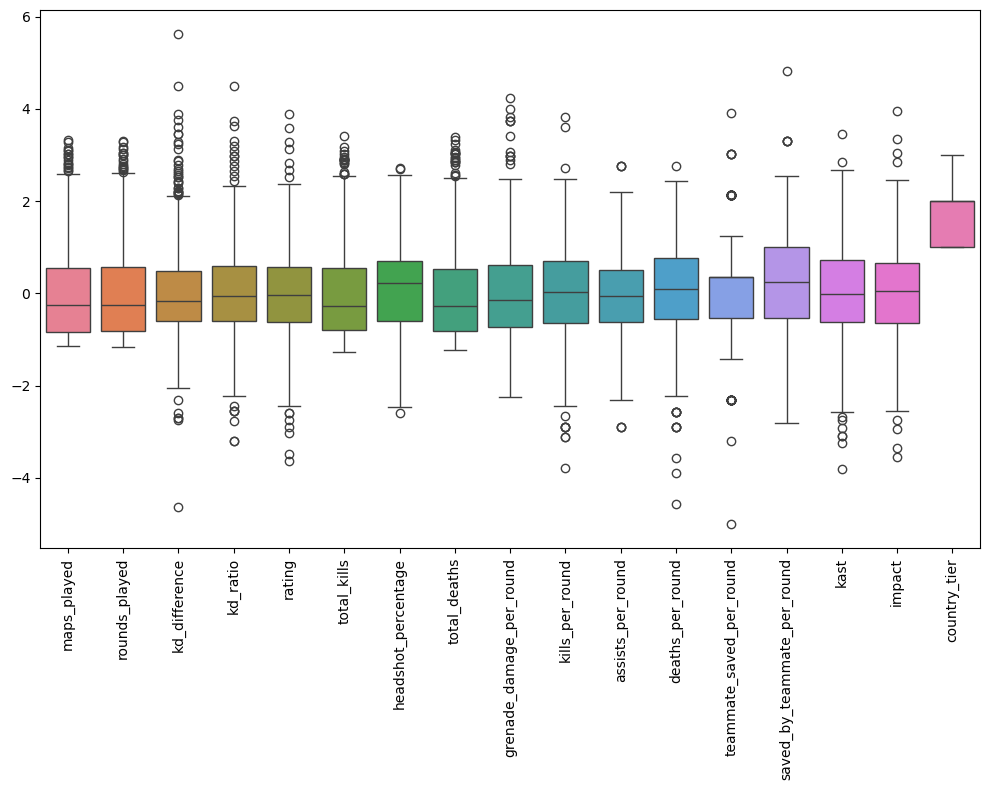

In [11]:
plt.figure(figsize=(10,8))
sns.boxplot(num_df_scaled)
plt.xticks(rotation=90)
plt.tight_layout()

<Axes: >

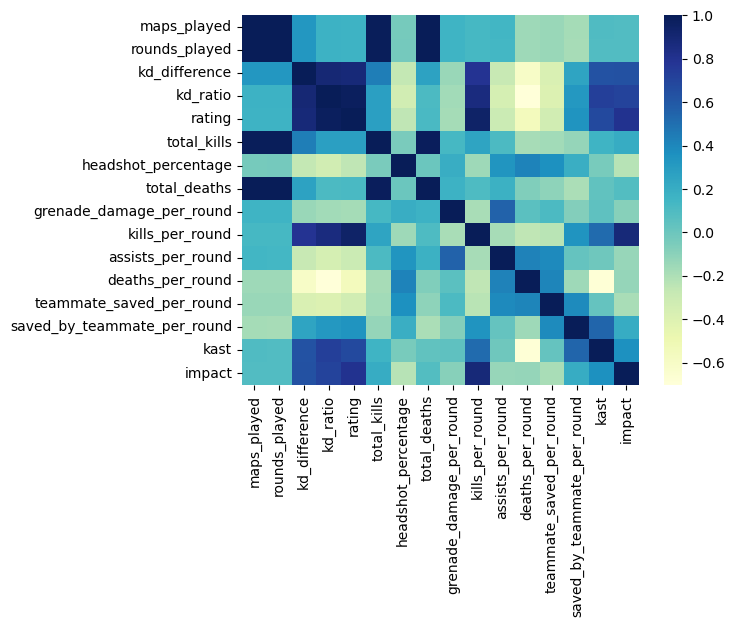

In [12]:
# TCorrelation Matrix
sns.heatmap(num_df_scaled.iloc[:,:-1].corr(), cmap="YlGnBu")

In [13]:
# Initialize PCA and fit to the data
pca = PCA()
df_pca = pca.fit_transform(num_df_scaled)

# Get standard deviations (sqrt of the eigenvalues)
std_dev = np.round(np.sqrt(pca.explained_variance_),4)

# Get proportion of variance
prop_variance = np.round(pca.explained_variance_ratio_,4)

# Get cumulative proportion
cumulative_prop = np.round(np.cumsum(prop_variance),4)

# Create a DataFrame for summary
pca_summary = pd.DataFrame({
    'Standard Deviation': std_dev,
    'Proportion of Variance': prop_variance,
    'Cumulative Proportion': cumulative_prop
})

# Set appropriate index labels for components
pca_summary.index = [f'PC{i+1}' for i in range(len(std_dev))]

print("Importance of components : \n",pca_summary)

Importance of components : 
       Standard Deviation  Proportion of Variance  Cumulative Proportion
PC1               2.4562                  0.3701                 0.3701
PC2               1.9683                  0.2376                 0.6077
PC3               1.4473                  0.1285                 0.7362
PC4               1.1239                  0.0775                 0.8137
PC5               1.0316                  0.0653                 0.8790
PC6               0.8304                  0.0423                 0.9213
PC7               0.6258                  0.0240                 0.9453
PC8               0.5694                  0.0199                 0.9652
PC9               0.4966                  0.0151                 0.9803
PC10              0.4004                  0.0098                 0.9901
PC11              0.2932                  0.0053                 0.9954
PC12              0.2520                  0.0039                 0.9993
PC13              0.0734           

In [14]:
# Set the target variance threshold (e.g., 90%)
target_variance = 0.99

# Fit PCA for all components
pca = PCA()
pca.fit(num_df_scaled)

# Calculate the cumulative explained variance for each number of components
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain the target variance
optimal_components = np.argmax(cumulative_variance >= target_variance) + 1  # +1 for actual number

print(f'Optimal number of principal components: {optimal_components}')

# Create an interactive plot using Plotly
fig = go.Figure()

# Add a line trace for the cumulative explained variance
fig.add_trace(go.Scatter(
    x=np.arange(1, len(cumulative_variance) + 1),
    y=cumulative_variance,
    mode='lines+markers',
    name='Cumulative Explained Variance',
    line=dict(color='blue'),
    marker=dict(size=8, color='blue')
))

# Add a horizontal line for the target variance threshold
fig.add_trace(go.Scatter(
    x=[1, len(cumulative_variance)],
    y=[target_variance, target_variance],
    mode='lines',
    name=f'{target_variance * 100}% Target Variance',
    line=dict(color='red', dash='dash')
))

# Update layout for interactivity and readability
fig.update_layout(
    title='Cumulative Explained Variance by Principal Components',
    xaxis_title='Number of Principal Components',
    yaxis_title='Cumulative Explained Variance',
    xaxis=dict(tickmode='linear'),
    hovermode='x unified',
    template='plotly_white'
)

# Add annotations to show the optimal number of components
fig.add_annotation(
    x=optimal_components,
    y=cumulative_variance[optimal_components - 1],
    text=f"Optimal PCs: {optimal_components}",
    showarrow=True,
    arrowhead=2,
    ax=50,
    ay=-40
)

# Show interactive plot
fig.show()


Optimal number of principal components: 10


In [15]:
# Use the Optimal Components for PCA
pca = PCA(n_components=optimal_components)
df_pca = pca.fit_transform(num_df_scaled)

In [16]:
# Get factor loadings (component loadings)
factor_loadings = np.round(pca.components_.T,3)  # Transpose to match the original feature space

# Create a DataFrame for factor loadings
factor_loadings_df = pd.DataFrame(
    factor_loadings,
    index=num_df_scaled.columns,  # Features as index
    columns=[f'PC{i+1}' for i in range(factor_loadings.shape[1])]  # Principal components as columns
)
print("Rotation (n x k) = (52 X 52)")
print(factor_loadings_df)

Rotation (n x k) = (52 X 52)
                               PC1    PC2    PC3    PC4    PC5    PC6    PC7  \
maps_played                  0.191  0.444  0.016  0.023 -0.116 -0.028  0.011   
rounds_played                0.190  0.444  0.018  0.023 -0.117 -0.022  0.025   
kd_difference                0.377 -0.055 -0.015  0.005  0.017  0.077 -0.019   
kd_ratio                     0.384 -0.152 -0.014  0.042  0.061  0.036 -0.020   
rating                       0.379 -0.149 -0.075 -0.113  0.057  0.054  0.004   
total_kills                  0.230  0.415 -0.000 -0.026 -0.108 -0.011  0.022   
headshot_percentage         -0.135  0.077 -0.399 -0.088 -0.177  0.828  0.055   
total_deaths                 0.168  0.457  0.003 -0.029 -0.120 -0.028  0.028   
grenade_damage_per_round    -0.055  0.179 -0.279  0.231  0.687  0.029  0.529   
kills_per_round              0.338 -0.137 -0.146 -0.364  0.054  0.030 -0.013   
assists_per_round           -0.119  0.202 -0.431 -0.029  0.388 -0.157 -0.603   
deaths_per_

Factor Loadings Shape: (17, 10)
Number of Features: 17


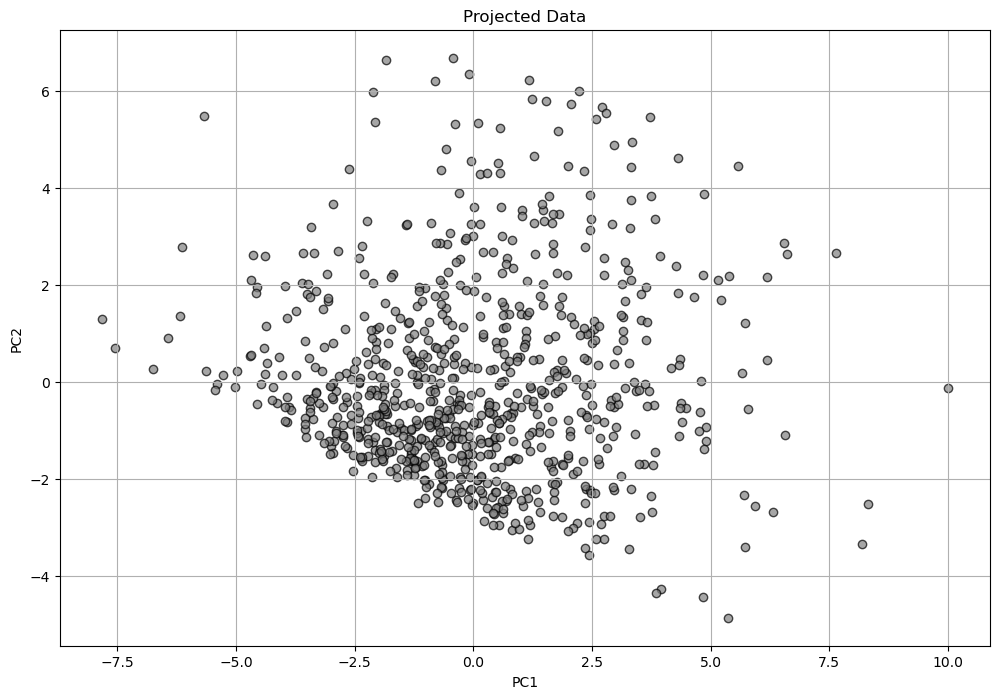

In [17]:
# Plotting the data 

plt.figure(figsize=(12, 8))
plt.scatter(df_pca[:,0], df_pca[:,1],c='grey', edgecolor='k', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Projected Data')

# Get the factor loadings
factor_loadings = pca.components_.T  # Transpose to match feature space
features = num_df_scaled.columns

# Check dimensions
print("Factor Loadings Shape:", factor_loadings.shape)  # Should be (n_features, n_components)
print("Number of Features:", len(features))  # Should match number of rows in factor_loadings

# Optional: (As the features is alot, it has been omitted)
#for i in range(factor_loadings.shape[0]):
#    plt.arrow(0, 0, factor_loadings[i, 0] * 2, factor_loadings[i, 1] * 2,
#              color='red', head_width=0.1, head_length=0.1)
#    plt.text(factor_loadings[i, 0] * 2.5, factor_loadings[i, 1] * 2.5, features[i], color='red')

plt.grid()
plt.show()


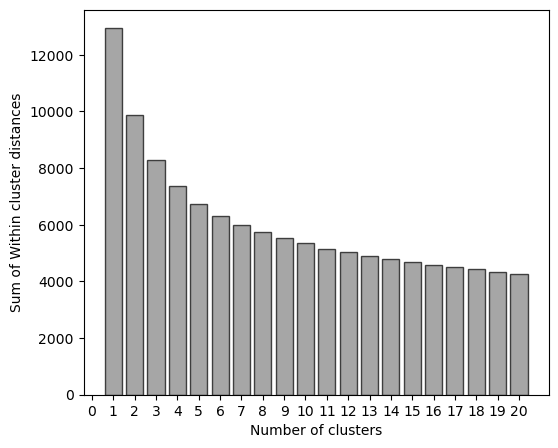

In [18]:
WCSS = []
for i in range(1,21):
    model = KMeans(n_clusters = i, n_init=25,init="k-means++",max_iter=600,random_state=69)
    model.fit(df_pca)
    WCSS.append(model.inertia_)
fig = plt.figure(figsize = (6,5))
plt.bar(range(1,21),WCSS, linewidth=1,color='grey', edgecolor='k',alpha=0.7)
plt.xticks(np.arange(21))
plt.xlabel("Number of clusters")
plt.ylabel("Sum of Within cluster distances")
plt.show()

In [20]:
kl = KneeLocator(range(1,21),WCSS,curve='convex',direction='decreasing')
print(f"Ideal number of segments : {kl.elbow}")

Ideal number of segments : 5


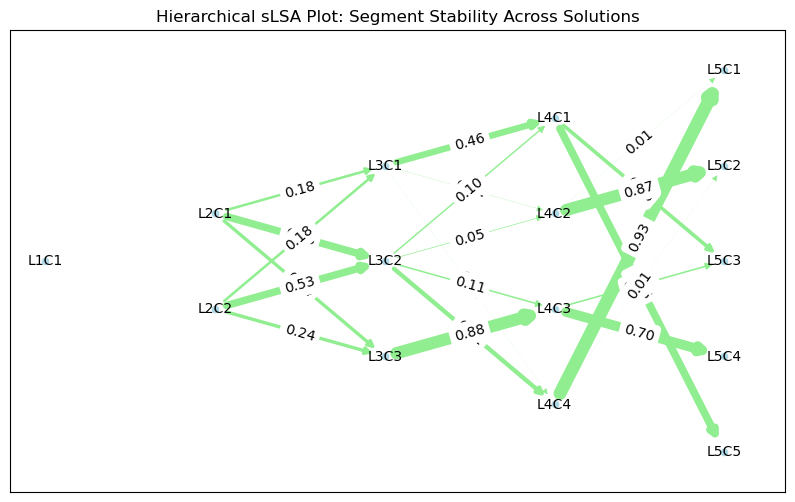

In [21]:
# List of k values (clusters) from 1 to 10
k_values = list(range(1, 6))

# Perform KMeans clustering for each k value
cluster_assignments = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=25,init="k-means++",max_iter=600,random_state=69)
    kmeans.fit(df_pca)
    cluster_assignments.append(kmeans.labels_)

# Initialize a graph
G = nx.DiGraph()  # Directed graph to show hierarchical connections

# Add nodes for each solution (clusters for each k)
for level, k in enumerate(k_values):
    for cluster in range(k):
        G.add_node(f'L{level+1}C{cluster+1}', label=f'{cluster+1}', level=level)

# Add edges based on similarity (Adjusted Rand Index) between successive levels
for level in range(len(k_values) - 1):
    current_clusters = cluster_assignments[level]
    next_clusters = cluster_assignments[level + 1]

    # Loop through clusters in the current and next level and calculate ARI
    for cluster_current in np.unique(current_clusters):
        for cluster_next in np.unique(next_clusters):
            # Create a binary mask for the current and next clusters
            mask_current = (current_clusters == cluster_current)
            mask_next = (next_clusters == cluster_next)

            # Calculate Adjusted Rand Index between clusters
            ari = adjusted_rand_score(mask_current, mask_next)

            # Add an edge if ARI is positive
            if ari > 0:
                G.add_edge(f'L{level+1}C{cluster_current+1}', f'L{level+2}C{cluster_next+1}', weight=ari)

# Set node levels for layout
for node in G.nodes():
    G.nodes[node]['level'] = G.nodes[node]['level']  # This line ensures the level is set for each node
plt.figure(figsize=(10, 6))
# Plot the hierarchical network graph
pos = nx.multipartite_layout(G, subset_key='level')

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=20)

# Draw edges with thickness proportional to ARI
edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[10 * d['weight'] for (_, _, d) in edges], edge_color='lightgreen')

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=10)

# Show edge labels (ARI values)
edge_labels = {(i, j): f'{d["weight"]:.2f}' for i, j, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Set plot title
plt.title('Hierarchical sLSA Plot: Segment Stability Across Solutions')
plt.show()


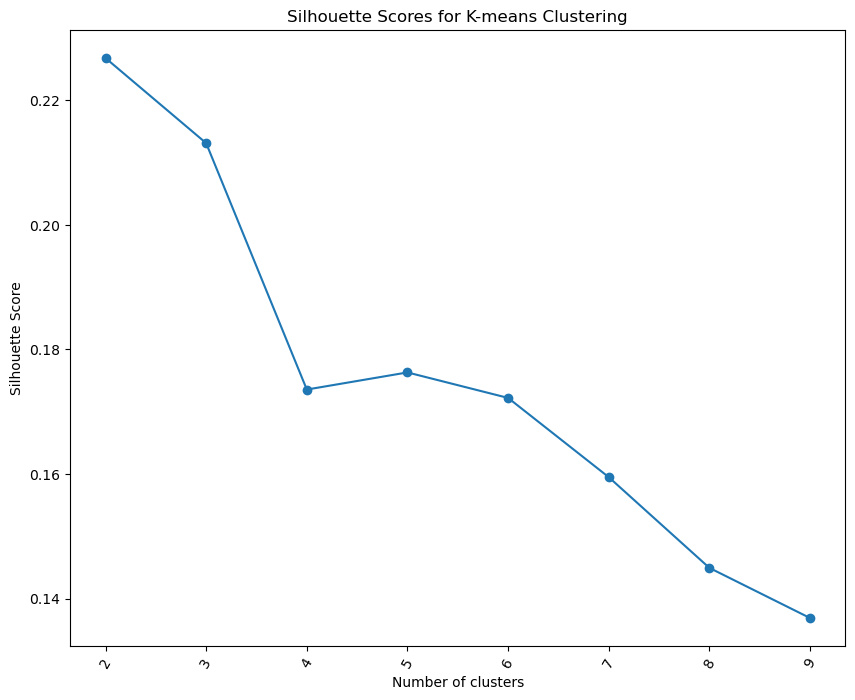

In [22]:
# K-means clustering from k=2 to k=20
results = []
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, n_init=25,init="k-means++",max_iter=600,random_state=69).fit(df_pca)
    results.append(kmeans)
    silhouette_scores.append(silhouette_score(df_pca, kmeans.labels_))

# Plot silhouette scores (equivalent to AIC/BIC/ICL plot)
plt.figure(figsize=(10, 8))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title('Silhouette Scores for K-means Clustering')
plt.xticks(rotation=60)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

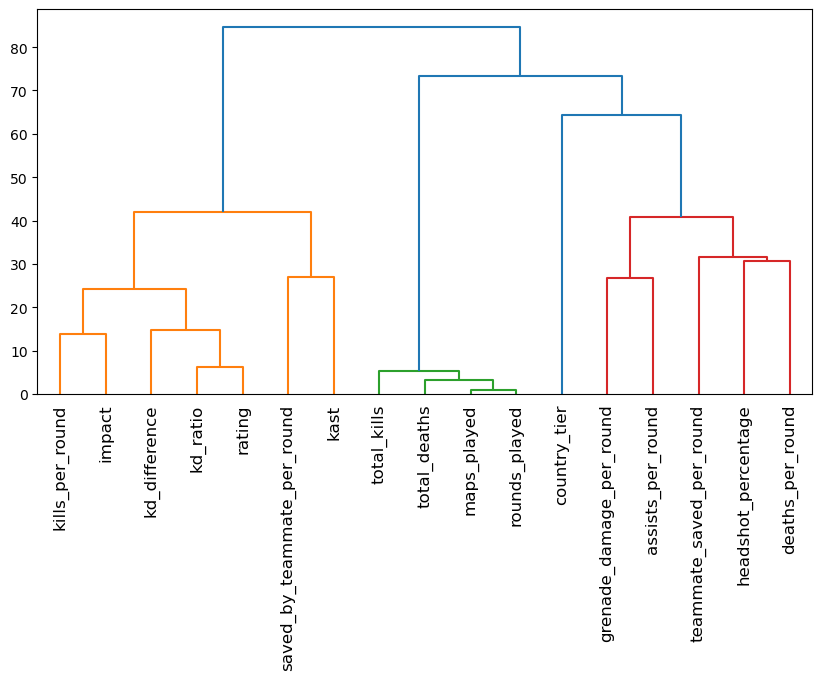

In [23]:
# Step 1: Hierarchical clustering
dist_matrix = pdist(num_df_scaled.T)
Z = linkage(dist_matrix, method='ward')

# Step 2: Plot a dendrogram
plt.figure(figsize=(10, 5))
dendro = dendrogram(Z, labels=num_df_scaled.columns, orientation='top', leaf_rotation=90)

# Extract the order of clustered variables
cluster_order = dendro['ivl']

# Show the plot
plt.show()

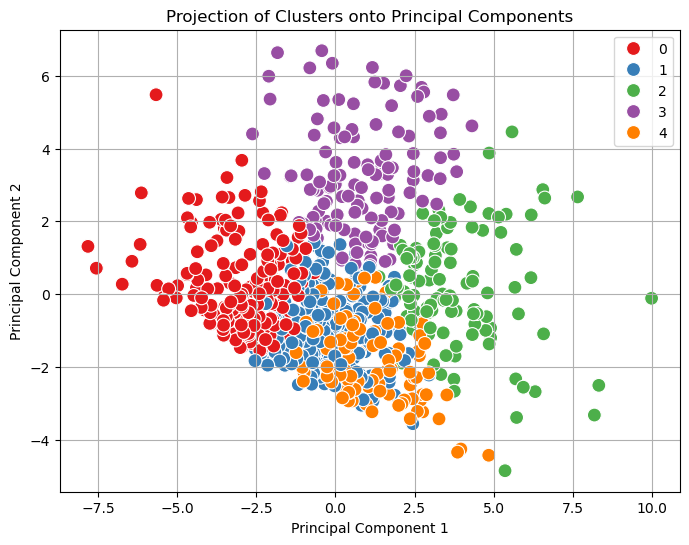

In [24]:
# Step 1: Perform KMeans clustering on the data
kmeans = KMeans(n_clusters=kl.elbow, n_init=25,init="k-means++",max_iter=600,random_state=69)
kmeans.fit(df_pca)  # Fit KMeans to the original data
cluster_labels = kmeans.labels_  # Get the cluster labels and adjust to [1, 2, 3, 4]

# Step 3: Create a scatter plot of the projected data (first two principal components)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=cluster_labels, palette='Set1', s=100)

# Label the axes
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Projection of Clusters onto Principal Components')

# Show the plot
plt.grid(True)
plt.show()


In [25]:
data = num_df_scaled.copy()
data["cluster"] = kmeans.labels_

<Axes: xlabel='cluster', ylabel='percent'>

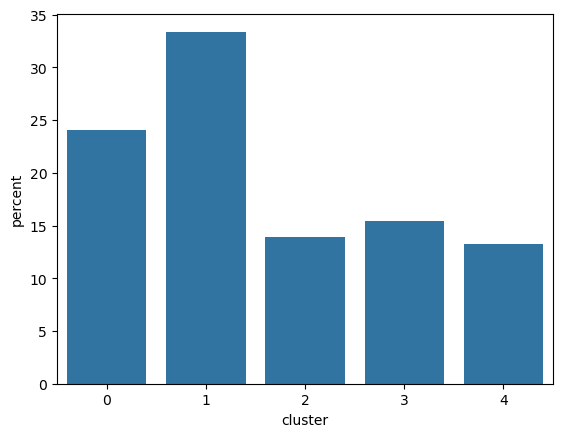

In [26]:
data['cluster'] = kmeans.predict(df_pca)
sns.countplot(x=data['cluster'],stat='percent')

In [27]:
X,y = data.drop(["cluster"],axis=1),data["cluster"]
X,y

(     maps_played  rounds_played  kd_difference  kd_ratio    rating  \
 0       0.340245       0.339341       3.614875  3.743036  3.880408   
 1       1.737775       1.751736       5.612994  3.308519  3.579740   
 2       0.034380       0.053900       3.237898  4.503439  3.279073   
 3      -1.131885      -1.101258       1.111634  3.634407  3.128739   
 4      -0.010380      -0.026091       2.395121  3.091261  2.828072   
 ..           ...            ...            ...       ...       ...   
 798     0.163689       0.126251      -2.707641 -2.557450 -2.734277   
 799    -0.940409      -0.935521      -1.573995 -2.557450 -2.884611   
 800     1.852163       1.816729      -4.626432 -2.774708 -3.034944   
 801    -1.116965      -1.104465      -1.703497 -3.209225 -3.485946   
 802    -1.052311      -1.065130      -1.727227 -3.209225 -3.636279   
 
      total_kills  headshot_percentage  total_deaths  grenade_damage_per_round  \
 0       0.857317            -0.494807      0.160898            

In [28]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
X_train.shape,X_test.shape

((642, 17), (161, 17))

In [29]:
#using logisitc regression for classification 

clf = LogisticRegression()
clf.fit(X_train,y_train)

## predictions
preds = clf.predict(X_test)

In [30]:
## performmance of the model
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       0.93      1.00      0.96        54
           2       0.95      0.91      0.93        22
           3       1.00      0.96      0.98        25
           4       1.00      0.90      0.95        21

    accuracy                           0.97       161
   macro avg       0.98      0.95      0.96       161
weighted avg       0.97      0.97      0.97       161



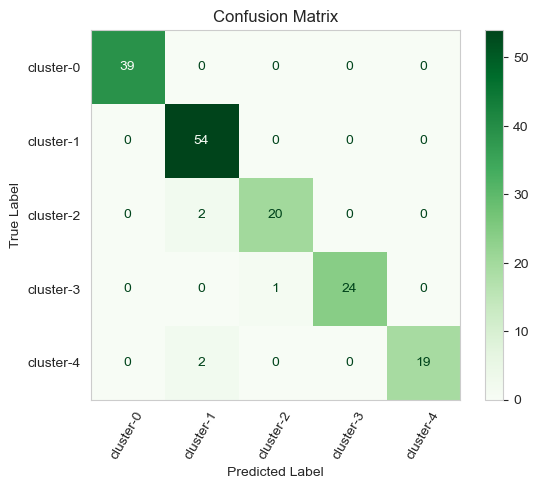

In [31]:
sns.set_style("whitegrid", {'axes.grid' : False})

cm = confusion_matrix(y_test,preds,labels=[i for i in range(0,kl.elbow)])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=[f"cluster-{i}" for i in range(0,kl.elbow)])
disp.plot(cmap='Greens',colorbar=True,)
plt.xlabel('Predicted Label')
plt.xticks(rotation=60)
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('count12.png')
plt.show()

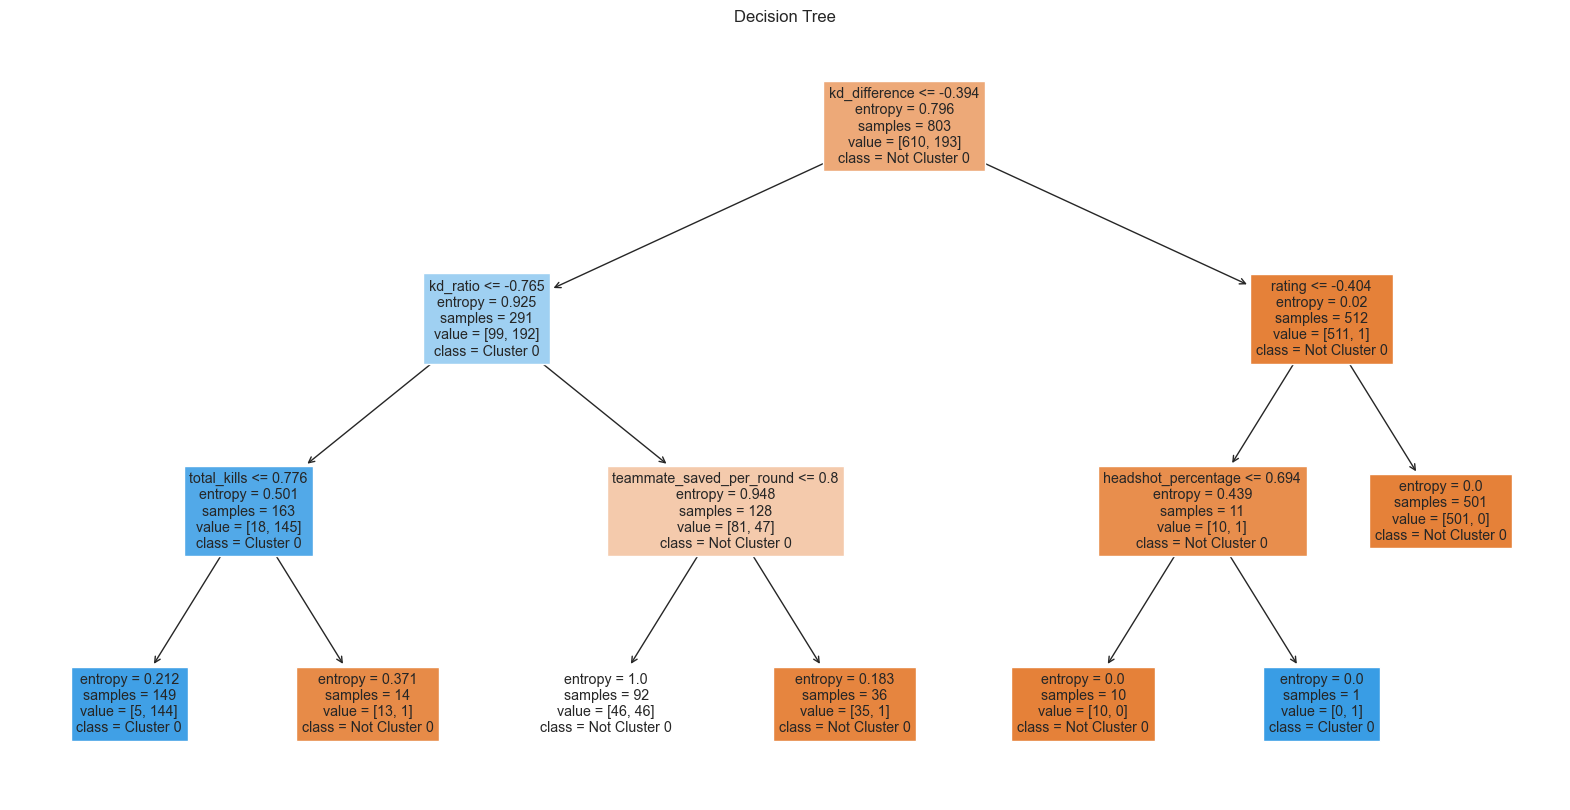

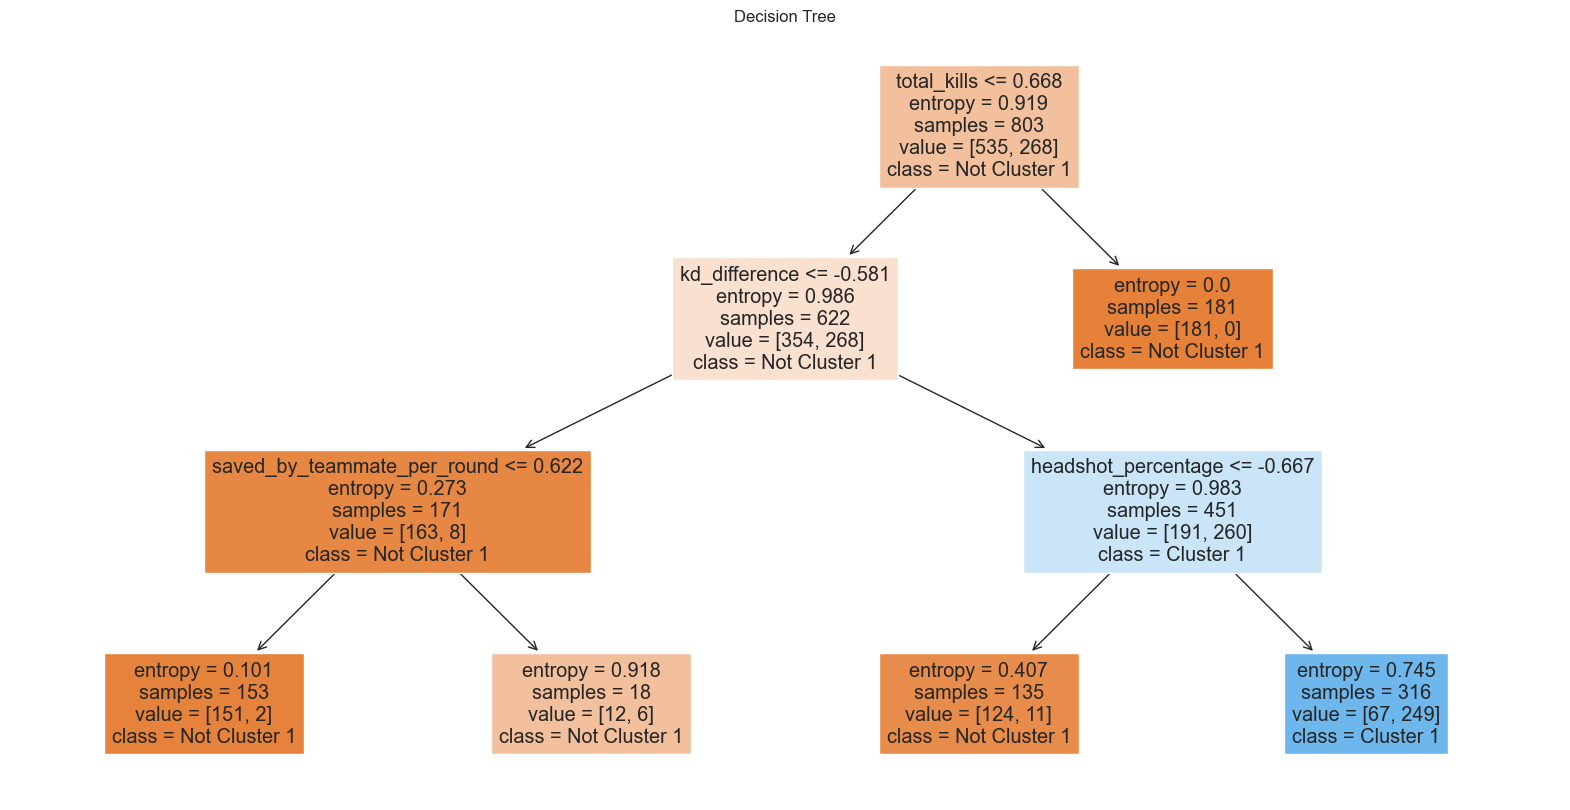

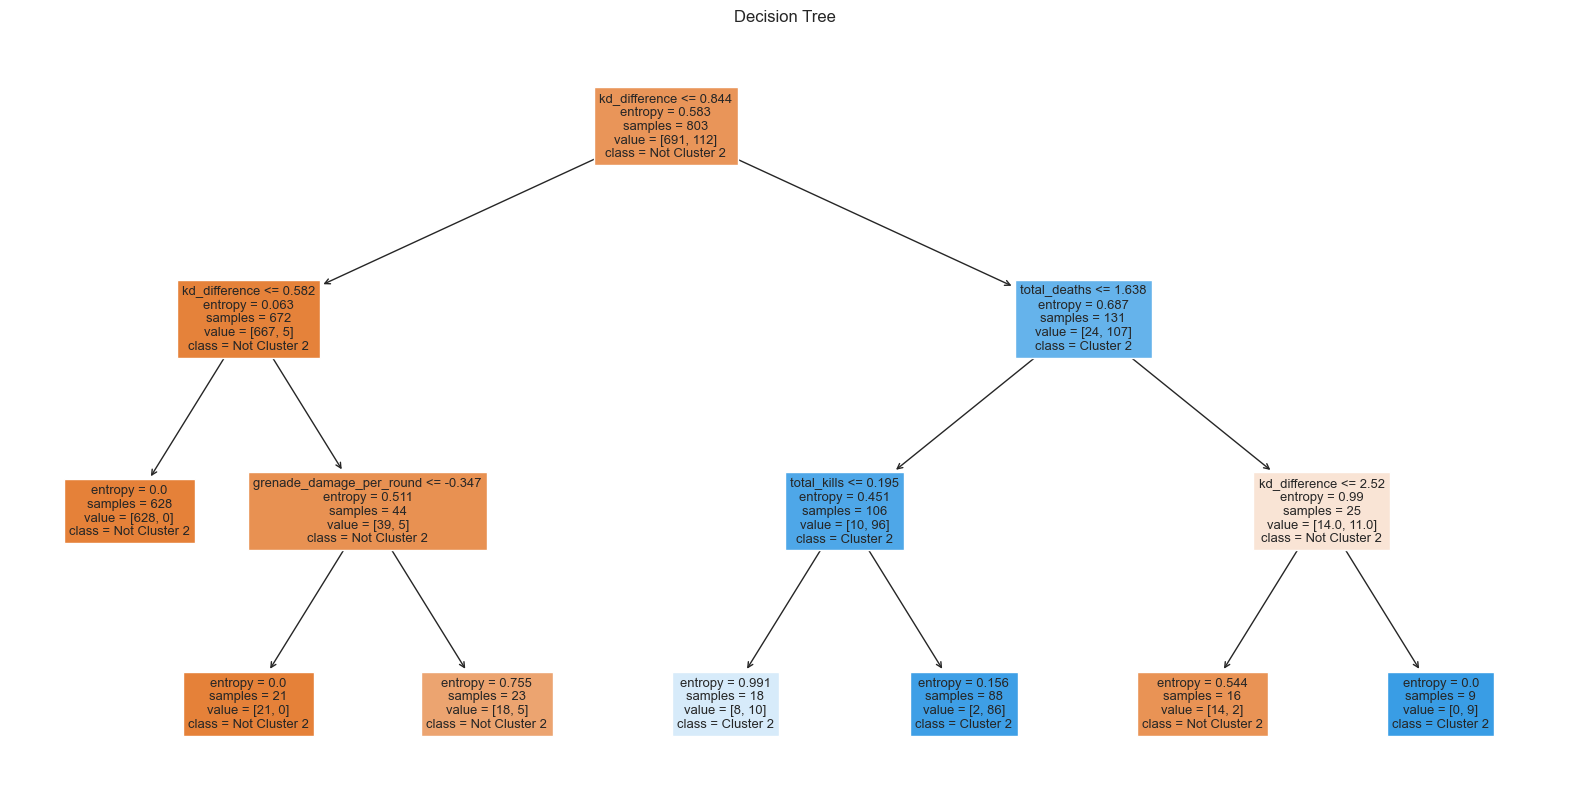

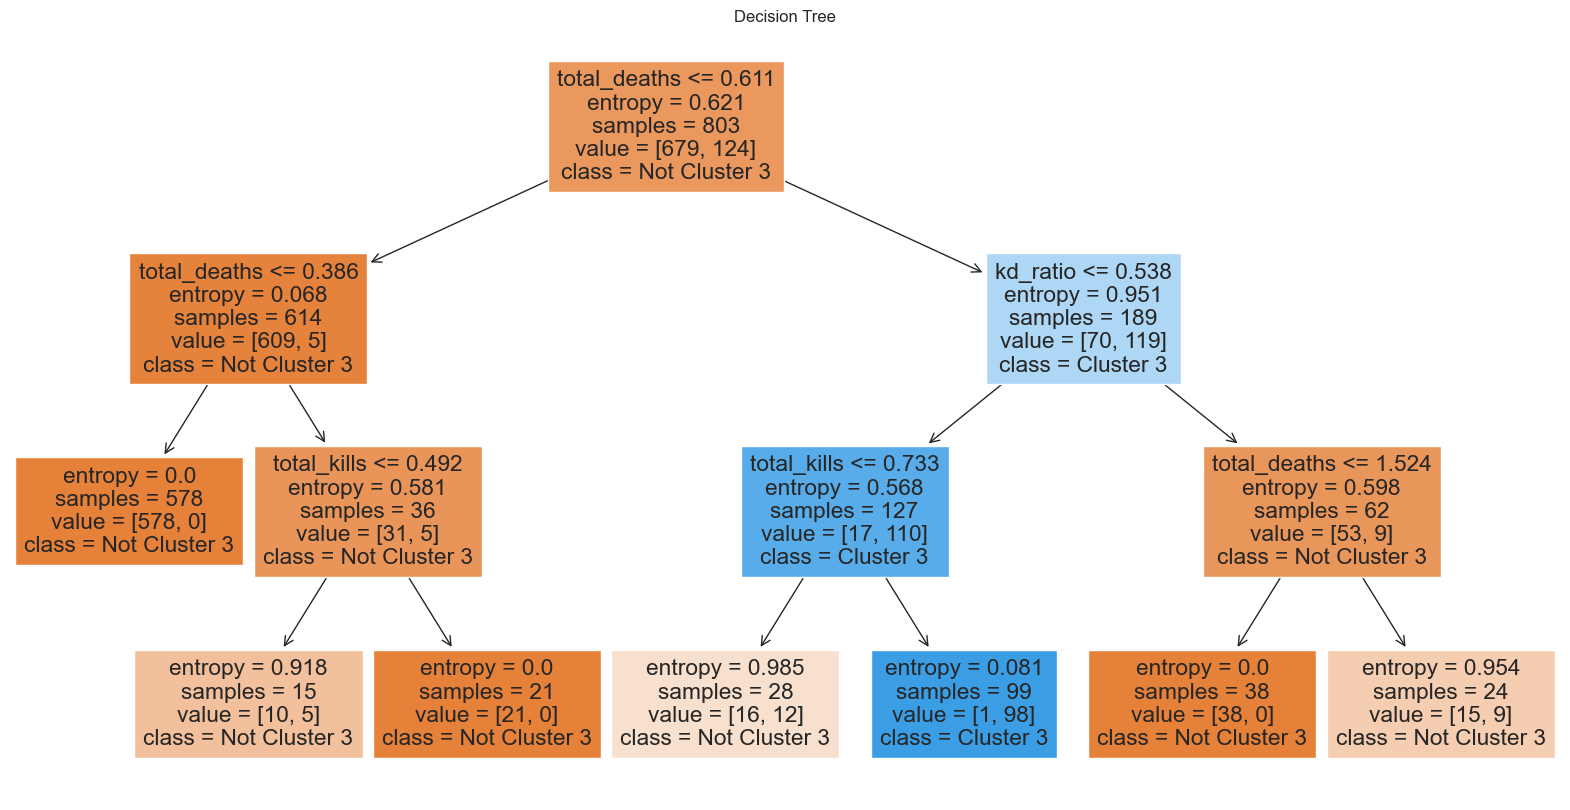

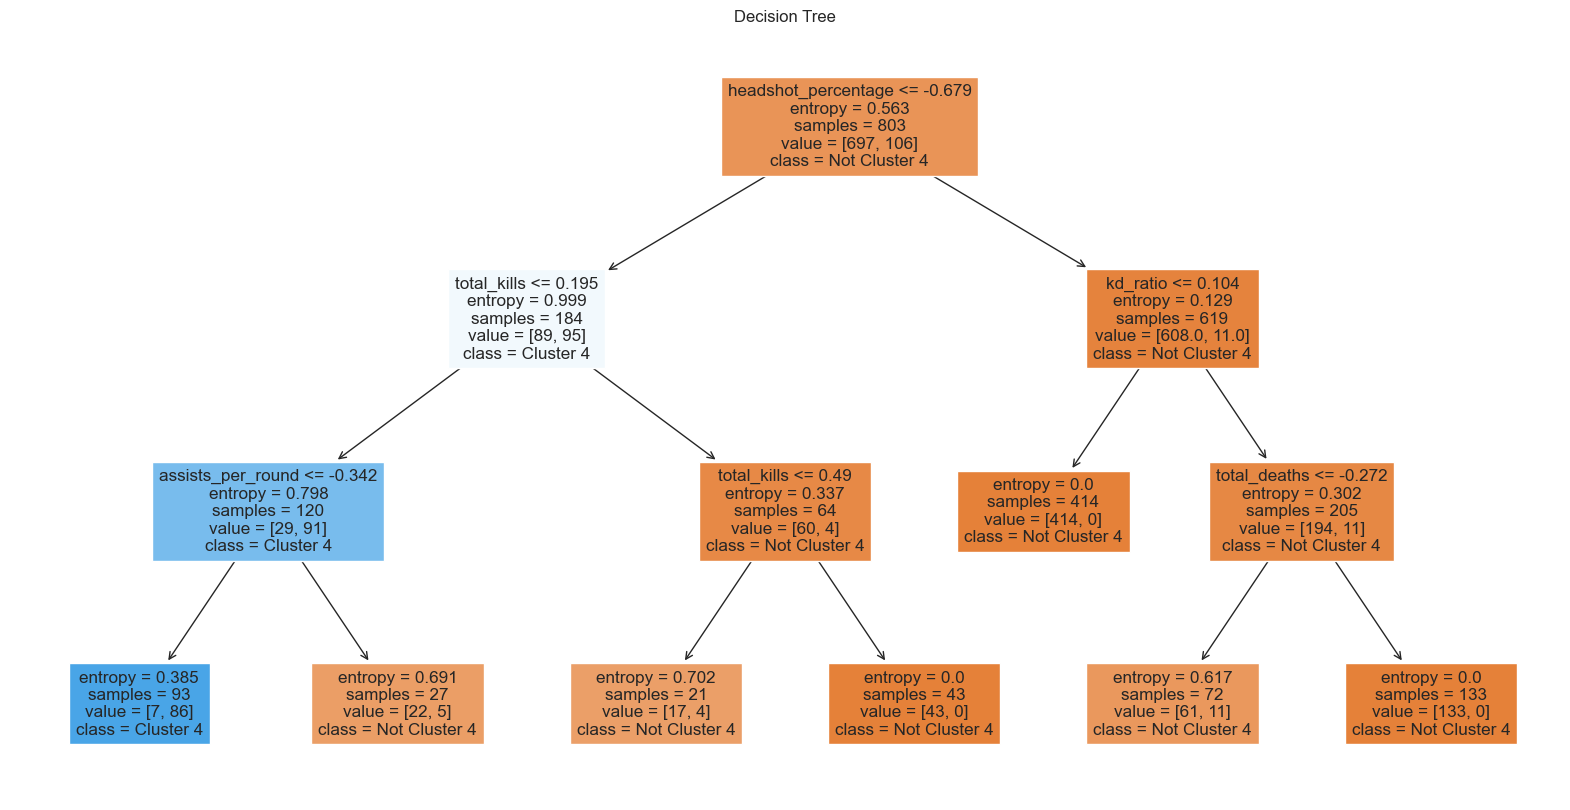

In [32]:
for i in range(0,kl.elbow):

    # Define the target and features
    X = data.drop(columns=["cluster"],axis=1)
    y = (kmeans.labels_ == i).astype(int)  # Target variable

    # Convert categorical variables to dummy variables
    X = pd.get_dummies(X, drop_first=True)

    # Create and fit the decision tree classifier with max depth of 3
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=3)  # Set max_depth to 3
    tree.fit(X, y)

    # Plot the tree
    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=X.columns, class_names=[f'Not Cluster {i}', f'Cluster {i}'],filled=True)
    plt.title('Decision Tree')
    plt.show()


In [33]:
data.columns.to_list()

['maps_played',
 'rounds_played',
 'kd_difference',
 'kd_ratio',
 'rating',
 'total_kills',
 'headshot_percentage',
 'total_deaths',
 'grenade_damage_per_round',
 'kills_per_round',
 'assists_per_round',
 'deaths_per_round',
 'teammate_saved_per_round',
 'saved_by_teammate_per_round',
 'kast',
 'impact',
 'country_tier',
 'cluster']

In [35]:
# Feature combinations list
feature_combinations = [
    ('kd_difference', 'rating', 'headshot_percentage'),
    ('rating', 'kd_ratio', 'total_kills'),
    ('saved_by_teammate_per_round',  'kd_difference', 'teammate_saved_per_round'),
    ('total_deaths', 'rounds_played', 'kd_ratio'),
    ('headshot_percentage', 'assists_per_round', 'grenade_damage_per_round')
]

# Group by 'cluster' and calculate the mean for each feature
median_df = data.groupby('cluster').median().reset_index()

# Define a consistent color map for the clusters
cluster_color_map = {
    '0': 'chartreuse',  
    '1': 'turquoise',  
    '2': 'fuchsia',
    '3': 'gainsboro',
    '4': 'mediumpurple',
}


# Loop over feature combinations and create 3D scatter plots
for combination in feature_combinations:
    x_feature, y_feature, z_feature = combination
    
    # Create 3D scatter plot for all points without legend
    fig = px.scatter_3d(data, 
                        x=x_feature, 
                        y=y_feature, 
                        z=z_feature,
                        color=data['cluster'].astype(str),  # Color based on cluster
                        title=f'{x_feature} vs {y_feature} vs {z_feature} (All Points & Cluster Means)',
                        labels={x_feature: x_feature, y_feature: y_feature, z_feature: z_feature},
                        opacity=0.3,
                        category_orders={'cluster': ['0', '1', '2','3','4']},
                        color_discrete_map=cluster_color_map)  # Apply the color map to individual points
    
    # Remove legend for the first scatter plot (individual points)
    fig.update_traces(showlegend=False,marker=dict(size=5))
    
    # Add the mean values as a separate trace (with larger, distinct markers)
    fig_mean = px.scatter_3d(median_df, 
                             x=x_feature, 
                             y=y_feature, 
                             z=z_feature,
                             color=median_df['cluster'].astype(str),  # Color based on cluster
                             opacity=1,
                             category_orders={'cluster': ['0', '1', '2','3','4']},
                             color_discrete_map=cluster_color_map)  # Apply the same color map to mean points
    
    # Update marker size and style for the mean values
    fig_mean.update_traces(marker=dict(size=10, symbol='diamond', opacity=1, 
                                       line=dict(width=2, color='black')))  # Border for diamonds

    # Combine the mean plot with the original plot
    fig.add_traces(fig_mean.data)

    # Save the plot as a PNG file
    #fig.write_image(f"Cars_Plots/{x_feature} vs {y_feature} vs {z_feature}.png")
    
    # Show the plot
    fig.show()


In [36]:
# Assigning clusters
df["cluster"] = kmeans.labels_

# Extract unique features
unique_features = list(set([feature for combo in feature_combinations for feature in combo]))

# Group by 'cluster' and calculate the median for numerical features
summary_df = df.groupby('cluster')[unique_features].median()

# Display the DataFrame
summary_df


,saved_by_teammate_per_round,kd_ratio,teammate_saved_per_round,grenade_damage_per_round,total_kills,assists_per_round,rounds_played,kd_difference,rating,total_deaths,headshot_percentage
cluster,,,,,,,,,,,
0,0.090,0.94,0.10,4.2,10033.0,0.14,15532.0,-624.0,0.940,10620.0,48.50
1,0.105,1.03,0.10,3.9,10910.5,0.14,15675.0,318.0,1.015,10423.5,49.60
2,0.100,1.15,0.09,3.8,21532.5,0.12,29392.0,2703.0,1.090,18377.5,41.55
3,0.090,1.02,0.10,4.4,25973.5,0.14,37865.5,565.5,1.010,25262.5,47.35
4,0.090,1.09,0.09,2.9,10389.5,0.11,14431.5,815.5,1.040,9417.5,32.50


### Cluster Analysis Summary

| **Cluster** | **Characteristics**                                          | **Prominent Reasoning**                                          | **Target Demographic**                      | **Recommended Advertising Strategy**                               | **Potential Ad Types**                                   | **Potential Partners for Ads**           |
|-------------|-------------------------------------------------------------|------------------------------------------------------------------|--------------------------------------------|-------------------------------------------------------------------|---------------------------------------------------------|------------------------------------------|
| 0           | High kill/death ratio (1.19), low deaths (18,204).          | Indicates strong individual performance and effectiveness in securing kills. | Competitive players looking to improve skills. | Showcase high-end gaming gear and competitive events.              | Premium gaming peripherals, coaching services, esports events. | ``Logitech``, ``Razer``, ``NVIDIA``, ``Esports organizations`` (e.g., ``Team Liquid``, ``Cloud9``) |
| 1           | Moderate kill/death ratio (0.92), high headshot percentage (47.90). | Suggests good accuracy but lower overall kill count.              | Supportive players interested in improving performance. | Promote tutorials and skill enhancement tools.                   | Online courses, guides, strategy games.                  | ``SkillCapped``, ``GamerSensei``, ``Twitch``, ``YouTube Gaming`` |
| 2           | Average kill/death ratio (1.00), decent headshot percentage (49.80).  | Indicates balanced gameplay with potential for growth.           | Casual players enjoying the gaming experience. | Highlight engaging games and social experiences.                  | Mobile games, social gaming platforms.                    | ``King``, ``Discord``, ``Steam``       |
| 3           | Balanced performance (1.02 kd ratio), high kills (27,400).   | Shows well-rounded capabilities with a focus on kills.           | Aggressive players seeking thrill and excitement. | Advertise fast-paced games and competitive events.               | FPS games, action movie promotions.                       | ``Activision``, ``EA``, ``Red Bull``    |
| 4           | Good kill/death ratio (1.08), lower kills (10,389.5).         | Indicates a tactical playstyle focused on survival and strategy. | Cautious players focused on strategy.      | Promote strategy games and tactical gear.                       | Strategy games, survival gear.                            | ``Ubisoft``, ``Epic Games``             |